In [309]:
import numpy as np
import connect_four_speedboost as cccc
import sys
import random
import pickle
import time
import random
from matplotlib import pyplot as plt
import matplotlib
from IPython import display
%matplotlib inline

In [310]:
def board_to_cache(board):
    #convert a tic tac toe board to a cache-able string
    one_to_ex_d = {1:"X",0:"_",-1:"O"}
    one_to_ex_f = lambda x: one_to_ex_d[x]
    return ''.join(map(one_to_ex_f,list(board.astype(int).reshape(42))))

def cache_to_board(s):
    ex_to_one_d = {'X':1,'_':0,'O':-1}
    ex_to_one_f = lambda x: ex_to_one_d[x]
    return np.array(map(ex_to_one_f,list(s))).reshape((6,7))

def board_to_paint(board):
    plt.matshow(board)
    plt.show
    
def board_to_plot(ax,board):
    ax.matshow(board,vmin=-1,vmax=1)
    return ax

In [490]:
#TREE_CACHE = {}
initializations = 0
class MCTS_node():
    def __init__(self,agent,board,player,leaf_branch = 40,policy = "uniform",net = "none", cache = {}):
#         global TREE_CACHE
        global initializations
        initializations +=1
        self.cache = cache
        self.game = agent(board,player)
        self.board = board
        self.player = player
        cache[board_to_cache(board)] = self
        self.children = {}
        self.parents = {}
        self.net=net
        self.leaf_branch = leaf_branch
        self.actions = self.game.legal_moves()
        self.terminal = self.game.over
        self.weakly_solved = (0.5,0)
        self.strongly_solved = (0.5,0,0)
        self.winner = self.game.winner
        if net == 'none':
            self.net_eval = 0
        else:
            if self.terminal:
                self.net_eval = self.winner
            else:
                self.net_eval = self.player * net.predict(self.player * self.board.reshape((1,6,7)))[0,0]
        if self.actions:
            if policy == 'uniform':
                #connect-four specific uniform policy
                self.priors = softmax(np.ones(len(self.actions)))
            else:
                self.priors = policy(self.game)
        #number and value of rollouts
        self.N = {action : 0 for action in self.actions}
        self.Vr = {action : 0 for action in self.actions}
        self.Vn = {action : 0 for action in self.actions}
        self.R = {action : (0.5,0) for action in self.actions}
        
        #check to see if any children are already expanded, and if so, add them to the children dictionary
        xgame = agent(np.copy(board),player)
        for action in self.actions:
            xgame.update_move(action)
            if board_to_cache(xgame.board) in cache:
                child = cache[board_to_cache(xgame.board)]
                self.children[action] = child
                child.parents[action] = self
                if child.weakly_solved[0] != 0.5:
                    propagate_result(self,action,-child.weakly_solved[0],abs(child.weakly_solved[1])+1)
                
            xgame.erase_move(action)

                    
    def is_leaf(self):
        return self.children == {}

    
    
def tree_policy(node,game,agent,mode = "puct",policy = 'uniform',net='none',leaf_branch=40,mix = 0.5):
    global EPSILON
    #global TREE_CACHE
    cache = node.cache
    current_node = node
    nodes_visited = [node]
    log = []
    simulation = agent(np.copy(game.board),game.player)
    #tree policy
    while(True):
        #epsilon greedy
        if mode == "epsilon":
            if np.random.random() < EPSILON:
                move = random.choice(simulation.legal_moves())
            else:
                move = max([(score , key) for key,score in node_score(current_node,mix).items()])[1]      
        if mode == "puct":
            if max(current_node.Vn.values()) == -np.inf:
                log.append('weakly solved')
                return simulation,nodes_visited,log
            #untested
            puct_constant = 3
            if net == 'none':
                q = np.array([node_score(current_node,mix)[move] for move in current_node.actions])*2
            else:
                q = np.array([node_score(current_node,mix)[move] for move in current_node.actions])
            u = puct_constant * current_node.priors * np.sqrt(np.sum(current_node.N.values())+1) / (
                        1 + np.array([current_node.N[move] for move in current_node.actions]))
            move = current_node.actions[np.argmax(q+u)]
            
            
#         print q+u,move
#         sys.exit()
        try:
            simulation.update_move(move)
        except:
            sys.exit((simulation.board,current_node.board,current_node.actions))
        log.append(move)
        
        if simulation.over:
            if simulation.result != 0:
                propagate_result(current_node,move,1,1)
            if simulation.result == 0:
                propagate_result(current_node,move,0,1)
            
        if move in current_node.children:
            current_node = current_node.children[move]
        #expansion
        elif current_node.N[move] >= current_node.leaf_branch:
            cache_b = board_to_cache(simulation.board)
            if cache_b in cache:
                current_node.children[move] = cache[cache_b]
                cache[cache_b].parents[move] = current_node
                if cache[cache_b].weakly_solved[0] != 0.5:
                    propagate_result(current_node,move,-cache[cache_b].weakly_solved[0],abs(cache[cache_b].weakly_solved[1])+1)
                current_node = cache[cache_b]
            else:
                new_node = MCTS_node(agent,np.copy(simulation.board),simulation.player,policy = policy,net=net,leaf_branch=leaf_branch,cache = cache)
                cache[board_to_cache(simulation.board)] = new_node
                current_node.children[move] = new_node
                new_node.parents[move] = current_node
                if new_node.weakly_solved[0]!=0.5:
                    propagate_result(current_node,move,-new_node.weakly_solved[0],abs(new_node.weakly_solved[1])+1)
                current_node = new_node
        else:
            return simulation, nodes_visited , log
        if current_node.weakly_solved == (0.5,0):
            nodes_visited.append(current_node)
            continue
        else:
            log.append("solved")
            return simulation, nodes_visited , log

def reverse_solved(result,depth):
    if result == 1:
        return -1,-depth + 1
    if result == -1:
        return 1 , -depth - 1
    if result == 0:
        return 0,0
    if result == 0.5:
        return result,depth

def propagate_result(node,move,result,depth):
#     degugging
#     print node.R,result,-depth*result
    node.R[move] = (result,-depth*result)
    node.N[move] += 1
    node.Vr[move] = -np.inf
    node.Vn[move] = -np.inf
    if max(node.R.values()) != node.weakly_solved:
        node.weakly_solved = max(node.R.values())
            
        for last_move,parent in node.parents.items():
            propagate_result(parent , last_move,-node.weakly_solved[0],abs(node.weakly_solved[1])+1)
            


def rollout(simulation,policy = 'uniform'):

    while(not simulation.over):
        if policy == 'uniform':
            move = random.choice(simulation.legal_moves())
        else:
            #put policy rollout stuff here
            move = policy_to_index(policy(simulation))
        simulation.update_move(move)  

    return simulation.result

def backprop(nodes , log , result, net_eval):
    for node,move in zip(nodes,log):
        node.N[move] += 1
        node.Vr[move] += result * node.player
        node.Vn[move] += net_eval * node.player
        
def MCTS(node,game,agent, dur = 5,policy = "uniform",net="none",rollout_policy = 'uniform',leaf_branch=40,mix = 0.5):
    t0 = time.clock()
    # debugging stuff
    t00=0
    global t1
    global t2
    global t3
    if node.weakly_solved[0] != 0.5:
        return node
    while(time.clock()-t0 < dur):
        #tree policy
        t00 = time.clock()
        if rollout == 'none':
            mix = 0
        simulation , nodes_visited , log = tree_policy(node,
                                                       game,
                                                       agent,
                                                       mode = 'puct',
                                                       policy = policy,
                                                       net=net,
                                                       leaf_branch=leaf_branch,
                                                       mix = mix)
        
        if log[-1] == "solved":
            continue
        if log[-1] == "weakly solved":
            #should try to find strong solution
            break
        else:
            t1 += time.clock()-t00

            leaf = nodes_visited[-1]

            #need to query if terminal
            net_eval = leaf.net_eval

            #rollout
            t00 = time.clock()
            if rollout_policy == 'none':
                result = 0
            else:
                result = rollout(simulation,rollout_policy)
        t2 += time.clock()-t00
        #backprop
        t00=time.clock()
        backprop(nodes_visited,log,result,net_eval)
        t3 += time.clock()-t00

    return node


def robust_score(node):
    action_values = []
    for key in node.N.keys():
        action_values.append((node.R[key][0],node.R[key][1],node.N[key],key))
    robust_action = max(action_values)
    if node.game.over:
        return node.game.result
    if robust_action[2]==0 and robust_action[0] == 0.5:
        return 0
    
    if robust_action[0] == 0.5:
        return float(node.Vr[robust_action[3]])/robust_action[2],float(node.Vn[robust_action[3]])/robust_action[2]
    else:
        if robust_action[0] == 1:
            return "win in {}".format(-robust_action[1])
        if robust_action[0] == 0:
            return "draw"
        if robust_action[0] == -1:
            return "lose in {}".format(robust_action[1])
        sys.exit('bad value somewhere')
def node_score(node,mix = 0.5):

    return {key : float(mix*node.Vr[key]+(1-mix)*node.Vn[key]) / float(node.N[key]) if node.N[key]>0 else 0 for key in node.actions}

def principal(node,mix=0.5):
    win_d = {1:'win',0:'tie',-1:'loss'}
    action_values = []
    for key in node.N.keys():
        action_values.append((node.R[key][0]if node.R[key][0] != 0.5 else -node.R[key][0],node.R[key][1],node.N[key],key))
    robust_action = max(action_values)
    move = robust_action[3]
    if move in node.children and not node.children[move].game.over:
        if robust_action[0] == -0.5:
            return [(move,node.Vr[move],node.N[move],node_score(node,mix)[move]*node.player)] + principal(node.children[move],mix)
        else:
            return [(move, '{} in {}'.format(win_d[robust_action[0]],(abs(robust_action[1])+1)/2),
                     0,win_d[robust_action[0]])] + principal(node.children[move],mix)
    else:
        if robust_action[0] == -0.5:
            return [(move,node.Vr[move],node.N[move],node_score(node,mix)[move]*node.player)]
        else:
            return [(move, '{} in {}'.format(win_d[robust_action[0]],(abs(robust_action[1])+1)/2),
                     0,win_d[robust_action[0]])]
    
def softmax(ar,temp=1):
    temp = float(temp)
    ar = np.copy(ar)
    if temp == 0:
        argmax = np.argmax(ar)
        cand = np.ones(ar.shape) * (ar == np.max(ar))
        return cand / np.sum(cand)
    ar = ar - np.max(ar)
    return np.exp(ar / temp) / np.sum(np.exp(ar/temp))

def get_principal(node):
    if len(node.children)==0:
        return ''
    move = max(((node.R[key][0],node.R[key][1],node.N[key],key) for key in node.children.keys()))[3]
    if move in node.children.keys():
        return str(move) + get_principal(node.children[move])
    else:
        return str(move)
    
from colorama import Fore, Back, Style,init

def alternate_red_blue(s,start):
    colour_d = {1:Fore.RED,-1:Fore.BLUE}
    new_s = colour_d[start]
    start *= -1
    for letter in s:
        new_s += letter + colour_d[start]
        start *= -1
        
    return new_s+Fore.BLACK
        
        
    
def print_eval(node):
    win_d = {1:' win',0:' tie',-1:'loss'} 
    moves = node.actions    
    evals = {move:'{:+1.7f}'.format(node_score(node,mix=1)[move]) if node.R[move][0]==0.5
             else '{} in {:2d}'.format(win_d[node.R[move][0]], (abs(node.R[move][1])+1)/2) for move in moves}
    runs = {move:'{:5d}'.format(node.N[move]) for move in node.N.keys()}
    principals = {move:alternate_red_blue(str(move),node.player) if not move in node.children.keys() else alternate_red_blue(str(move)
                                                + get_principal(node.children[move]),node.player) for move in moves}
    _,_,_,order = zip(*sorted(((node.R[move][0],node.R[move][1],node.N[move],move) for move in moves),reverse=True))
    strings = []
    for move in order:
        strings.append("move {}: eval: {} runs: {} principal branch: ".format(move,evals[move],runs[move]) + principals[move])
    s = '\r'
    for phrase in strings:
        s = s + phrase+'\n'
#     print "moves",moves
#     print 'evals',evals
#     print 'principal',principals
#     print 'order',order
    return s

def reduce_effect_recursive(by = 0.5):
    for node in TREE_CACHE.values():
        for move in node.N:
            node.N[move] *= by
            node.V[move] *= by
            
def net_to_policy(net,game,temp = 1):
    board = game.board * game.player
    game = cccc.Board(np.copy(board),1)
    actions = game.legal_moves()
    #convnet
    values = []
    for move in actions:
        game.update_move(move)
        # first minus because it is the other player's point of view, second minus to get it to that point of view
        if game.game_over():
            values.append(game.winner())
        else:
            values.append(- net.predict( - game.board.reshape(1,6,7,1))[0,0])
        game.erase_move(move)
    values = np.array(values)
    return softmax(values, temp)

def policy_to_index(policy):
    return np.random.choice(np.arange(policy.size),p=policy)


def alpha_beta(game, depth=0, alpha=(-np.inf,0), beta=(np.inf,0), evaluation = 'none',cache = {},dur = np.inf):
    if board_to_cache(game.board) in cache.keys():
        return cache[board_to_cache(game.board)]
    # this copies the game to not affect the main line. maybe this is slow
#     print "start",depth,alpha,beta
    if dur < 0:
        return "quit"
    t0 = time.clock()
    if evaluation == 'none':
        evaluation = lambda x: 0
        
    if depth == 0:        
        return (random.choice(game.legal_moves()),(0,0))
    player = game.player
    moves = game.legal_moves()
    random.shuffle(moves)
    
    move_score = (None,(-np.inf,0))
    current = (None,(-np.inf,0))
    for move in moves:
        game.update_move(move)
        if game.over:
            current = (move,(game.result * player,-1))
        else:
            go_deeper = alpha_beta(game,depth = depth - 1, alpha = (-beta[0],-beta[1]),beta = (-alpha[0],-alpha[1]),
                                   evaluation=evaluation,cache=cache,dur = dur - (time.clock()-t0))
            if go_deeper == 'quit':
                game.erase_move(move)
                return 'quit'
            if go_deeper[1] != (0,0):
                cache[board_to_cache(game.board)] = go_deeper
            prop = (-go_deeper[1][0],-np.sign(go_deeper[1][1])*(np.abs(go_deeper[1][1])+1))
            current = (move,prop)
        if current[1] > move_score[1]:
            move_score = (move,current[1])
        if move_score[1] > alpha:
            alpha = move_score[1]
        game.erase_move(move)
        if alpha>=beta:
#             print "yay"
            break
#     print "end",depth,alpha,beta
    return move_score

def alpha_beta_descend(game,max_depth=np.inf,evaluation = 'none',cache = {},dur = np.inf):
    if board_to_cache(game.board) in cache.keys():
        return cache[board_to_cache(game.board)],0
    t0 = time.clock()
    move_score = (None,-np.inf)
    depth = 0
    while True:
        
        if depth > max_depth:
            break
        move_score_cand = alpha_beta(game,depth,dur = dur - (time.clock() - t0),cache = cache)
        if move_score_cand == 'quit':
            break
        move_score = move_score_cand
        if move_score[1]!=(0,0):
            break
        depth +=1
    return move_score,depth

def alpha_beta_rollout(depth,cache):
    def func(game):
        move=alpha_beta(game,depth = depth,cache=cache)[0]
#         print move
#         print game.legal_moves()
#         print np.array([i==move for i in range(7)]).astype(int)
        return np.array([i==move for i in range(7)]).astype(int)
    return func

In [23]:
import time
import random
game = cccc.Board()
TREE_CACHE = {}
t0 = 'error'
tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,40,{})
EPSILON = 0.1
pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)
for _ in range(60):
    print _ , max(node_score(tree).values())
    MCTS(tree,game,cccc.Board,dur = 60,policy = pass_policy)


scores = node_score(tree)
print 'current move\n'
for move in tree.actions:
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(move,tree.Vr[move],tree.N[move],scores[move])

print '\nprincipal variation\n'
for move in principal(tree):
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(*move)

connect_four_speedboost.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if board == None:


TypeError: 'dict' object is not callable

In [ ]:
import time
import random
game = cccc.Board()
TREE_CACHE = {}
t0 = 'error'
tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,40,{})
EPSILON = 0.1
pass_policy = lambda x: net_to_policy(net,x,temp = 1)
for _ in range(20):
    print _ , max(node_score(tree).values())
    MCTS(tree,game,cccc.Board,dur = 5,policy = 'uniform')


scores = node_score(tree)
print 'current move\n'
for move in tree.actions:
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(move,tree.Vr[move],tree.N[move],scores[move])

print '\nprincipal variation\n'
for move in principal(tree):
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(*move)

# Make initial training set

In [22]:
Z_cache = []
X=[]
y=[]

#unique
#Z_cache=set()
TREE_CACHE = {}
games_played = 0


def policy1(game,net):
    board = game.board * game.player
    actions = game.legal_moves()
    return actions[policy_to_index(net_to_policy(net,board,0.25))]

pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)

while len(Z_cache) < 30000:
    games_played +=1
    boards = []
    simulation = cccc.Board()
    tree = MCTS_node(cccc.Board,simulation.board,simulation.player,net=net, policy = pass_policy,leaf_branch = 5,cache = TREE_CACHE)
    while not simulation.game_over():
        boards.append(np.copy(simulation.board))
        # random
        #move = random.choice(simulation.legal_moves())
        
        # Neural Network
        move = policy1(simulation,net)
        
        simulation.update_move(move)        
    #unique
    board = random.choice(boards)
    cache = board_to_cache(board)
    if not cache in Z_cache:
        Z_cache.append(board_to_cache(random.choice(boards)))
        
    if games_played%1==0:
        sys.stdout.write('\r games played: {}, positions grabbed: {}'.format(games_played,len(Z_cache)))
Z = map(cache_to_board,Z_cache)
sys.stdout.write('\r games played: {}, positions grabbed: {}'.format(games_played,len(Z_cache)))

 games played: 2000, positions grabbed: 1505

KeyboardInterrupt: 

# Get MCTS rollout scores

In [ ]:
TREE_CACHE = {}
import time

pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)

for i,board in enumerate(Z):
    player = 1 if np.sum(board) == 0 else -1
    game = cccc.Board(np.copy(board) , player)
    tree = MCTS_node(cccc.Board,game.board,game.player,net=net, policy = pass_policy,leaf_branch = 5,cache = TREE_CACHE)
    MCTS(tree,game,cccc.Board,dur = 2.5,policy = pass_policy,leaf_branch=5,net=net)
    sys.stdout.write('\r'+str(i)+' '+str(sum(tree.N.values())))
    

In [ ]:
y = []
X = []
for board in Z:
    cache = board_to_cache(board)
    node = TREE_CACHE[cache]
    # if it is player two, then the board AND the result need to be reversed
    if node.player == 1:
        y.append(sum(robust_score(node))*0.5)
        X.append(board)
    else:
        y.append(sum(robust_score(node))*0.5)
        X.append(-1 * board)
#     if y[-1]==0.5:#some bugfixing 
#         break
        

#### No bias

In [ ]:
TREE_CACHE = {}
import time

pass_policy = lambda x: net_to_policy(net,x,temp = 0.5)
def roll_policy(board):
    player = 1 if np.sum(board)==0 else -1
    board = board*player
    game = cccc.Board(board,1)
    actions = game.legal_moves()
    net_eval = pol_net.predict(board.reshape(1,6,7,1)).reshape(7)
    net_eval = [net_eval[i] if i in actions else -np.inf for i in range(7)]
    return softmax(net_eval,0.2)  
y = []
y_pol = []
X = []
for i,board in enumerate(Z):
    player = 1 if np.sum(board) == 0 else -1
    game = cccc.Board(np.copy(board) , player)
    tree = MCTS_node(cccc.Board,game.board,game.player,net=net, policy = pass_policy,leaf_branch = 5)
    MCTS(tree,game,cccc.Board,dur = 1,policy = pass_policy,leaf_branch=5,net=net)
    sys.stdout.write('\r'+str(i)+' '+str(sum(tree.N.values())))

    cache = board_to_cache(board)
    # if it is player two, then the board AND the result need to be reversed
    if tree.player == 1:
        y_pol.append(node_score(tree))
        y.append(sum(robust_score(tree))*0.5)
        X.append(board)
    else:
        y_pol.append(node_score(tree))
        y.append(sum(robust_score(tree))*0.5)
        X.append(-1 * board)
#     if y[-1]==0.5:#some bugfixing 
#         break
z = []
for d in y_pol:
    a = -np.ones(7)
    for i in range(7):
        if i in d.keys():
            a[i]=d[i]
    z.append(a)
z = np.array(z)

#### Single game

In [30]:
Z_cache = set()
X=[]
y=[]
pol_y=[]
#unique
Z_cache=set()
games_played = 0


def policy1(game,net):
    board = game.board * game.player
    actions = game.legal_moves()
    return actions[policy_to_index(net_to_policy(net,board,0.25))]
t0 = time.clock()
while len(Z_cache) < 1000000:
    games_played +=1
    boards = []
    simulation = cccc.Board()
    while not simulation.game_over():
        boards.append(np.copy(simulation.board))
        move = policy1(simulation,net)
        simulation.update_move(move)       
        
    board = random.choice(boards)
    player = 1 if np.sum(board) == 0 else -1
    cache = board_to_cache(board)
    if not cache in Z_cache:
        Z_cache.add(board_to_cache(random.choice(boards)))
        X.append(board*player)
        y.append(simulation.winner()*player)
    if games_played%1000==0:
        sys.stdout.write('\r games played: {}, positions grabbed: {}'.format(games_played,len(Z_cache)))
Z = map(cache_to_board,Z_cache)
sys.stdout.write('\r games played: {}, positions grabbed: {}'.format(games_played,len(Z_cache)))
print ''
print time.clock()-t0

 games played: 2817601, positions grabbed: 1000000
127881.013158


#million
with open('training_set_mill2.pkl','wb') as file_:
    pickle.dump((X,y),file_)

In [5]:
with open('training_set_mill.pkl','rb') as file_:
    X,y = pickle.load(file_)

IOError: [Errno 2] No such file or directory: 'training_set_mill2.pkl'

In [ ]:
z = []
for d in y_pol:
    a = -np.ones(7)
    for i in range(7):
        if i in d.keys():
            a[i]=d[i]
    z.append(a)
z = np.array(z)

In [ ]:
print tree.N
print tree.Vn
print tree.Vr
print node_score(tree)
print robust_score(tree)
print tree.priors

In [ ]:
print TREE_CACHE[board_to_cache(-X[3758])].N
print TREE_CACHE[board_to_cache(-X[3758])].Vr
print TREE_CACHE[board_to_cache(-X[3758])].Vn
print TREE_CACHE[board_to_cache(-X[3758])].net_eval

In [ ]:
# import pickle
# with open('cache.pkl','wb') as file_:
#     pickle.dump(TREE_CACHE,file_)
    
with open('training_set_gen7.pkl','wb') as file_:
    pickle.dump((X,y,z),file_)

In [11]:
import pickle
# with open('cache.pkl','rb') as file_:
#     TREE_CACHE = pickle.load(file_)
with open('training_set_gen7.pkl','rb') as file_:
    X,y,z = pickle.load(file_)

In [13]:
#shuffle
cut = 25000
zipped = zip(X,y,z)
random.shuffle(zipped)
X,y,x = zip(*zipped)

#split
X_train,X_val = np.array(X[:cut]).reshape(-1,42),np.array(X[cut:]).reshape(-1,42)
y_train,y_val = np.array(y[:cut]).reshape(-1),np.array(y[cut:]).reshape(-1)
z_train,z_val = np.array(z[:cut]).reshape(-1,7),np.array(z[cut:]).reshape(-1,7)


In [ ]:
y,z

In [49]:
from sknn.mlp import Regressor, Convolution,Layer
net = Regressor( layers = [Convolution("Rectifier", channels = 36 , kernel_shape = (4,4)),
                           #Convolution("Rectifier", channels = 4 , kernel_shape = (3,3)),
                           Layer("Rectifier", units = 256,dropout=0.2),
                           Layer("Rectifier", units = 256,dropout=0.2),
                           Layer("Rectifier", units = 64,dropout=0.2),
                           Layer("Rectifier", units = 64,dropout=0.2),
                           Layer("Rectifier", units = 64,dropout=0.2),
                           #Layer("Rectifier", units = 21,dropout=0.2),
                           Layer("Tanh", units = 1)],
                batch_size = 32,
                learning_rate = 0.00001,
                learning_rule = 'nesterov',
                #weight_decay=0.000001,           
                n_iter = 1)


# def net_policy(board):
    
#     game = cccc.Board(np.copy(board),1)
#     actions = game.legal_moves()
#     values = np.zeros(len(actions))
#     for i,move in enumerate(actions):
#         game.update_move(move)
#         values[i] = net.predict(game.board.reshape(-1,42))[0,0]
#         game.erase_move(move)
#     return values

In [118]:
from sknn.mlp import Regressor, Convolution,Layer
pol_net = Regressor( layers = [Convolution("Rectifier", channels = 8 , kernel_shape = (4,4)),
                           #Convolution("Rectifier", channels = 4 , kernel_shape = (3,3)),
                            
                           Layer("Rectifier", units = 50,dropout=0.2),
#                            Layer("Rectifier", units = 50,dropout=0.2),
#                            Layer("Rectifier", units = 25,dropout=0.2),
#                            Layer("Rectifier", units = 128,dropout=0.2),
#                            Layer("Rectifier", units = 64,dropout=0.2),
#                            Layer("Rectifier", units = 21,dropout=0.2),
                           #Layer("Rectifier", units = 25,dropout=0.1),
                           Layer("Tanh", units = 7)],
                batch_size = 32,
                learning_rate = 0.0001,
                learning_rule = 'nesterov',
                #weight_decay=0.000001,           
                n_iter = 1)

In [ ]:
net = Regressor( layers = [#Convolution("Rectifier", channels = 12 , kernel_shape = (4,4)),
                           #Convolution("Rectifier", channels = 4 , kernel_shape = (3,3)),
                           Layer("Rectifier", units = ),
                           #Layer("Rectifier", units = 20),
                           #Layer("Rectifier", units = 50),
                           Layer("Tanh", units = 1)],
                batch_size = 16,
                learning_rate = 0.0001,
                learning_rule = 'nesterov',
                weight_decay=0.0001, 
                n_iter = 1)

with open('c4_shallow_net.pkl','rb') as file_:
    net2_params = pickle.load(file_)

In [ ]:
net.set_parameters(net2_params)

In [ ]:
net.fit(np.zeros((8,42)),np.zeros((8,1)))


In [14]:
X_train = X_train.reshape((-1,1,6,7))
X_val = X_val.reshape((-1,1,6,7))

print X_train.shape
print X_val.shape
print y_train.shape
print y_val.shape


(25000L, 1L, 6L, 7L)
(5000L, 1L, 6L, 7L)
(25000L,)
(5000L,)


In [ ]:
X_train = X_train.reshape((-1,42))
X_val = X_val.reshape((-1,42))

print X_train.shape
print X_val.shape
print y_train.shape
print y_val.shape

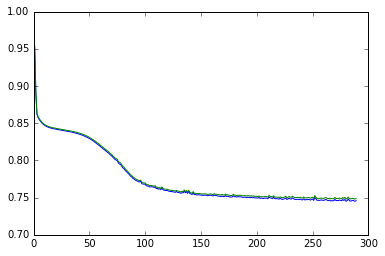

(0.74589340988998643, 0.74868364060142678)


KeyboardInterrupt: 

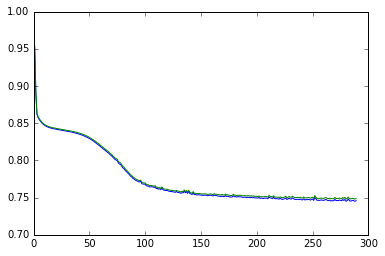

In [50]:
newgraph = True
if newgraph:
    mse = []
if not 'mse' in globals():
    mse = []
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
for epoch in range(2000):
    net.fit(X_train,y_train)
    
    if epoch % 1 == 0:
        mse.append((np.mean(np.abs(net.predict(X_train.reshape((-1,6,7,1))).reshape(-1) - y_train)**2),np.mean(
            np.abs(net.predict(X_val.reshape((-1,6,7,1))).reshape(-1) - y_val)**2)))
        display.clear_output(wait=True)
        plt.clf()
        plt.plot(mse)
        ax = plt.gca()
        ax.set_color_cycle(['blue','red'])
        display.display(plt.gcf())
        print mse[-1]         

KeyboardInterrupt: 

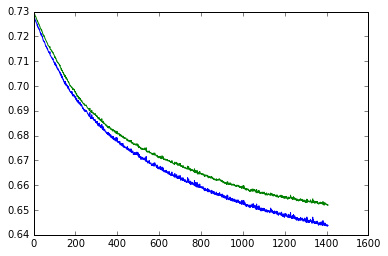

In [123]:
newgraph = True
if newgraph:
    msep = []
if not 'msep' in globals():
    msep = []
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
for epoch in range(10000):
    pol_net.fit(X_train,z_train)
    
    if epoch % 1 == 0:
        msep.append((np.mean(np.sum(np.abs(pol_net.predict(X_train.reshape((-1,6,7,1))).reshape(-1,7) - z_train)**2,axis=1)),np.mean(
            np.sum(np.abs(pol_net.predict(X_val.reshape((-1,6,7,1))).reshape(-1,7) - z_val)**2,axis=1))))
        display.clear_output(wait=True)
        plt.clf()
        plt.plot(msep)
        ax = plt.gca()
        ax.set_color_cycle(['blue','red'])
        display.display(plt.gcf())
        print msep[-1]      

In [51]:
with open('mill2_convdrop.pkl', 'wb') as file_:
    pickle.dump(net,file_)
with open('mill2_convdropstate.pkl','wb') as file_:
    pickle.dump(net.__getstate__()['weights'],file_)
# with open('gen5_policyconvdrop.pkl', 'wb') as file_:
#     pickle.dump(pol_net,file_)
# with open('gen5_policyconvdropstate.pkl','wb') as file_:
#     pickle.dump(pol_net.__getstate__()['weights'],file_)

In [24]:
with open('gen5_convdrop.pkl', 'rb') as file_:
    net = pickle.load(file_)
with open('gen5_policyconvdrop.pkl','rb') as file_:
    pol_net = pickle.load(file_)


In [27]:
import sknn
with open('gen5_convdropstate.pkl','rb') as file_:
    net_state = pickle.load(file_)
net.fit(np.zeros((1,1,6,7)),np.zeros(1))
net.set_parameters(net_state)

In [ ]:
with open('gen1_policyconvdropstate.pkl','rb') as file_:
    pol_net_state = pickle.load(file_)
pol_net.fit(np.zeros((1,1,6,7)),np.array([1,-1,0,1,0,-1,-1]).reshape(1,7))
pol_net.set_parameters(pol_net_state)

In [ ]:
igen = iter(range(5000))

In [ ]:

i=next(igen)
print i
board_to_paint(X_val[i].reshape((6,7)))
print 'target:', y_val[i]
print 'prediction', net.predict(X_val[i])[0,0]
print 'target policy: ',z_val[i]
print 'predicted policy: ', pol_net.predict(X_val[i])

In [ ]:
print test
np.sum(test,axis = 1)

In [ ]:
plt.hist(net.predict(X_val.reshape((-1,6,7,1))).reshape(-1) - y_val)

In [ ]:
index = 4400
board = X_val[index].reshape(6,7)
board_to_paint(board)
print y_val[index]
print net.predict(board.reshape(1,6,7,1))

In [ ]:
plt.hist(y_val)

In [ ]:
TREE_CACHE[board_to_cache(X[58])].Vr

In [ ]:
net.__getstate__()['weights']

# import pickle
with open('gen1_100_tanh.pkl', 'wb') as file_:
    pickle.dump(net,file_)

In [ ]:
with open('gen1_convdrop.pkl', 'wb') as file_:
    pickle.dump(net,file_)
with open('gen1_convdropstate.pkl','wb') as file_:
    pickle.dump(net.__getstate__()['weights'],file_)

In [ ]:
import pickle
with open('gen1_convdrop.pkl','rb') as file_:
    net = pickle.load(file_)

In [ ]:
test=net

In [ ]:
scores = node_score(tree)
print 'current move\n'
for move in tree.actions:
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(move,tree.Vr[move],tree.N[move],scores[move])

print '\nprincipal variation\n'
for move in principal(tree):
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(*move)

In [ ]:
zip(map(lambda x: x.reshape((6,7)),X_train),y_train)[100:150]

In [ ]:
game = cccc.Board()
tree = MCTS_node(cccc.Board,game.board,game.player)
board = tree.children[3].board
cache = board_to_cache(board)
node = TREE_CACHE[cache]
# if it is player two, then the board AND the result need to be reversed
if node.player == 1:
    print (max(node_score(node).values()))
    print (board)
else:
    print(-min(node_score(node).values()))
    print(-1 * board)

In [ ]:
node_score(tree.children[3])

In [ ]:
game = cccc.Board()
def policy1(game,net):
    board = game.board * game.player
    actions = game.legal_moves()
    return actions[policy_to_index(net_to_policy(net,board,0.2))]
    

def policy2(game):
    actions = game.legal_moves()
    return actions[policy_to_index(softmax(np.ones(len(game.legal_moves()))))]

    
score = 0
games = 0
longest = []
for i in range(1000):
    game = cccc.Board()
    while not game.game_over():
        if game.player == 1:
            game.update_move(policy1(game,net))
        else:
            game.update_move(policy2(game))
    score += game.winner()
    games +=1
    if len(game.log) > len(longest):
        longest = game.log
    if games%25==0:
        sys.stdout.write('\r{} , {}'.format(float(score)/games , games))
    
print "\n",score,games

### MTCS policy

500-0-500, games played: 1000
0 1000
time: 87.435249894


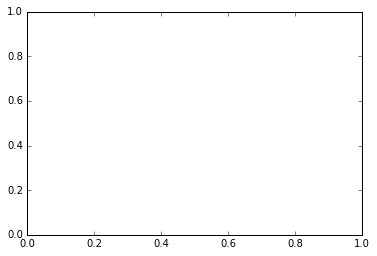

In [307]:
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

score = 0
wins = 0
ties = 0
losses = 0
games = 0
logs = []
longest = []
game = cccc.Board()
print_board = False

import time

pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)

def roll_policy(board):
    player = 1 if np.sum(board)==0 else -1
    board = board*player
    game = cccc.Board(board,1)
    actions = game.legal_moves()
    net_eval = pol_net.predict(board.reshape(1,6,7,1)).reshape(7)
    net_eval = [net_eval[i] if i in actions else -np.inf for i in range(7)]
    return softmax(net_eval,0.1)  
    
    
node = MCTS_node(cccc.Board,game.board,game.player,policy=pass_policy,net=net,cache={})


#MCTS
p1_cache = {}
p4_cache = {}
bp_cache = {}


def policy1(game,net,time = 5,mix = 0.5,rollout = 'uniform'):
    global node
    TREE_CACHE = {}
    tree = MCTS_node(cccc.Board,game.board,game.player,policy = pass_policy,net=net,cache = p1_cache)
    node = tree
    MCTS(tree,game,cccc.Board,dur = time,policy = pass_policy,net=net,leaf_branch=5,mix=mix,rollout_policy = rollout)
    
    return max(tree.N.items() , key = lambda x: x[1])[0]  #robust
    
    #return max(node_score(tree).items(), key = lambda x: x[1])[0] 

#RANDOM    
ones = [np.ones(i) for i in range(1,8)]
def policy2(game):
    actions = game.legal_moves()
    
    return actions[policy_to_index(softmax(ones[len(actions)-1]))]

#PURE NET

def policy3(game,net):
    board = game.board * game.player
    actions = game.legal_moves()
    try:
        return actions[policy_to_index(net_to_policy(net,board,0.5))]
    except:
        print net_to_policy(net,board)
        sys.exit()
#RANDOM MCTS

def policy4(game,time = 5):
    global TREE_CACHE
    global node
    TREE_CACHE = {}
    tree = MCTS_node(cccc.Board,game.board,game.player,leaf_branch=5,mix = 0.9999,cache = p4_cache)
    node = tree
    MCTS(tree,game,cccc.Board,dur = time)
    
    # return max(tree.N.items() , key = lambda x: x[1])[0]  #robust
    
    return max(node_score(tree).items(), key = lambda x: x[1])[0] 

def polpol(game,pol_net,temp = 0):
    board = game.board*game.player
    actions = game.legal_moves()
    net_eval = pol_net.predict(board.reshape(1,6,7,1)).reshape(7)
    net_eval = np.array([net_eval[i] for i in range(7) if i in actions])
    return actions[policy_to_index(softmax(net_eval,temp=temp))]

def bothpol(game,net,pol_net,mix=0.5,time = 5):
    global TREE_CACHE
    global node
    TREE_CACHE = {}
    tree = MCTS_node(cccc.Board,game.board,game.player,policy = pass_policy,net=net,cache = bpcache)
    node = tree
    MCTS(tree,game,cccc.Board,dur = time,policy = pass_policy,net=net,leaf_branch=5,mix=mix,rollout_policy = roll_policy)
    
    return max(tree.N.items() , key = lambda x: x[1])[0]

t0 = time.clock()
ax = plt.gca()
for _ in range(1000):
    game = cccc.Board()
    while not game.over:
        t1,t2,t3=0,0,0
        if game.player == 1:
            game.update_move(policy3(game,net2))
        else:
            game.update_move(policy3(game,net))
        if print_board:
            display.clear_output(wait=True)
            ax = board_to_plot(ax,game.board)
            display.display(plt.gcf())
            sys.stdout.write('\r{}-{}-{}, games played: {}'.format(wins,ties,losses,games))
            print ''
            print 'tree: {:1.2f}, rollout: {:1.2f}, backprob: {:1.2f}'.format(t1,t2,t3)
            for j,item in enumerate(principal(node)):
                if node.net == 'none':
                    print item[0],game.player*item[3]*(-1)**(j+1)*2
                else:
                    print item[0],game.player*item[3]*(-1)**(j+1)
            
    logs.append(game.log)
    score += game.winner()
    if game.result==1:
        wins+=1
    if game.result==0:
        ties+=1
    if game.result==-1:
        losses+=1
    games +=1
    if len(game.log) > len(longest):
        longest = game.log
    if games%10==0:
        sys.stdout.write('\r{}-{}-{}, games played: {}'.format(wins,ties,losses,games))
    
print "\n",score,games
print "time: {}".format(time.clock()-t0)

In [308]:
for item in logs:
    print item

[2, 0, 0, 2, 2, 0, 4, 4, 1, 5, 3]
[4, 5, 5, 1, 6, 3, 0, 1, 6, 6, 5, 4, 6, 4, 4, 3, 6, 1, 4, 5, 6, 2]
[4, 5, 3, 0, 5, 3, 6, 0, 0, 5, 3, 3, 0, 2, 0, 0, 4, 3, 6, 2, 1, 6, 1, 4, 4, 5]
[1, 1, 5, 3, 4, 2, 1, 5, 2, 4, 3, 1, 6, 6, 6, 0, 3, 6, 3, 6, 3]
[2, 1, 5, 4, 1, 0, 3, 6, 2, 5, 2, 5, 0, 4, 2]
[2, 4, 2, 1, 5, 0, 3, 3, 0, 6, 1, 2, 5, 3, 2, 4, 2, 5, 4, 4, 3]
[4, 2, 2, 4, 0, 0, 6, 1, 3, 5, 2, 4, 3, 4, 6, 4]
[5, 6, 1, 6, 6, 3, 4, 4, 3, 6, 2, 6, 1, 6, 2, 2, 3, 0, 2, 3, 0]
[3, 5, 2, 5, 6, 1, 0, 0, 0, 2, 5, 3, 3, 5, 5, 2, 5, 0, 6, 1]
[4, 5, 5, 1, 2, 2, 3, 1, 2, 1, 0, 1]
[1, 2, 2, 1, 6, 4, 2, 3, 6, 2, 0, 5]
[0, 4, 6, 3, 3, 3, 5, 3, 2, 2, 6, 0, 0, 2, 0, 3, 6, 6, 2, 1, 0, 0, 5, 4, 4, 4]
[2, 6, 4, 0, 0, 2, 3, 1, 5]
[0, 5, 6, 6, 0, 5, 4, 3, 4, 2, 3, 1, 2, 1, 2, 3, 0, 0, 4, 6, 2, 4, 4, 5, 3, 2, 4, 0, 0, 5]
[0, 0, 1, 6, 0, 4, 1, 6, 1, 1, 4, 4, 5, 2, 0, 2, 5, 6, 4, 4, 6, 3, 3, 6, 3, 4, 2]
[6, 5, 0, 1, 1, 2, 4, 0, 0, 4, 3, 6, 3, 1, 3, 3, 3, 6, 2, 2, 2, 6, 4, 6]
[4, 1, 2, 2, 0, 4, 2, 2, 5, 3, 2, 5, 3, 0, 0,

In [ ]:
net.predict(game.board.reshape((6,7)))

In [ ]:
game.update_move(next(testgen))
print game.board

In [ ]:
policy2(game)

In [ ]:
for move in game.legal_moves():
    game.update_move(move)
    print move , net.predict(game.board.reshape((1,6,7,1)))[0,0]
    game.erase_move(move)

In [ ]:
TREE_CACHE={}
initializations = 0
t1,t2,t3 = 0,0,0
game = cccc.Board()
for move in [3]:
    game.update_move(move)
pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)
tree = MCTS_node(cccc.Board,game.board,game.player,leaf_branch=5,policy=pass_policy,net=net)
MCTS(tree,game,cccc.Board,dur = 5,policy=pass_policy,net=net,leaf_branch=5)
print sum(tree.N.values())
print tree.N
print {key : 0 if tree.N[key]==0 else float(tree.Vr[key]) / tree.N[key] for key in tree.N.keys()}
print {key : 0 if tree.N[key]==0 else tree.Vn[key] / tree.N[key] for key in tree.N.keys()}
print node_score(tree)
print "time spent on tree policy {:1.2f}".format(t1)
print "time spent on rollout {:1.2f}".format(t2)
print "time spent on backprop {:1.2f}".format(t3)
print initializations

In [ ]:
net.predict(game.board.reshape(1,6,7,1))

In [ ]:
TREE_CACHE={}
initializations = 0
t1,t2,t3 = 0,0,0
game = cccc.Board()
pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)
tree = MCTS_node(cccc.Board,game.board,game.player)
MCTS(tree,game,cccc.Board,dur = 0.1)
print sum(tree.N.values())
print tree.N
print {key : 0 if tree.N[key]==0 else tree.Vr[key] / tree.N[key] for key in tree.N.keys()}
print {key : 0 if tree.N[key]==0 else tree.Vn[key] / tree.N[key] for key in tree.N.keys()}
print node_score(tree)
print "time spent on tree policy {:1.2f}".format(t1)
print "time spent on rollout {:1.2f}".format(t2)
print "time spent on backprop {:1.2f}".format(t3)

In [ ]:
current_node = tree
puct_constant=3
q = np.array([node_score(current_node)[move] for move in current_node.actions])
u = puct_constant * current_node.priors * np.sqrt(np.sum(current_node.N.values())+1) / (
            1 + np.array([current_node.N[move] for move in current_node.actions]))
print q
print u
print q+u

# Feature Extraction

Let's get a few features from a board

In [6]:
import sklearn as sk
import lasagne
import theano
from nolearn.lasagne import NeuralNet as NN,TrainSplit,BatchIterator
from lasagne.nonlinearities import tanh,rectify
from lasagne.layers import InputLayer,DenseLayer,DropoutLayer,Conv2DLayer as Conv
from lasagne.objectives import squared_error
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.
C:\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:

class BoardExtractor(TransformerMixin):
    def transform(self,X):
        X = X.reshape(-1,6,7)
        bunch = []
        for board in X:
            board = board.reshape((6,7))
            # Xs
            x = (board == 1).astype(float)

            # Os
            o = (board == -1).astype(float)

            # blanks
            blank = (board == 0).astype(float)

            #legal
            legal = blank-np.vstack((blank[1:],np.zeros((1,7))))
            
            
            #advanced features
            threat_factor = 3
            scale_win = 0.05
        
            xcol = x[0:3,:]+x[1:4,:]+x[2:5,:]+x[3:6,:]
            xrow = x[:,0:4]+x[:,1:5]+x[:,2:6]+x[:,3:7]
            xdiag = x[0:3,0:4] + x[1:4,1:5]+x[2:5,2:6]+x[3:6,3:7]
            xrdiag = x[3:6,0:4]+x[2:5,1:5]+x[1:4,2:6]+x[0:3,3:7]
            ocol = o[0:3,:]+o[1:4,:]+o[2:5,:]+o[3:6,:]
            orow = o[:,0:4]+o[:,1:5]+o[:,2:6]+o[:,3:7]
            odiag = o[0:3,0:4] + o[1:4,1:5]+o[2:5,2:6]+o[3:6,3:7]
            ordiag = o[3:6,0:4]+o[2:5,1:5]+o[1:4,2:6]+o[0:3,3:7]
            open_xcol = xcol * (np.logical_not(ocol))
            open_xrow = xrow * (np.logical_not(orow))
            open_xdiag = xdiag * (np.logical_not(odiag))
            open_xrdiag = xrdiag * (np.logical_not(ordiag))
            open_ocol = ocol * (np.logical_not(xcol))
            open_orow = orow * (np.logical_not(xrow))
            open_odiag = odiag * (np.logical_not(xdiag))
            open_ordiag = ordiag * (np.logical_not(xrdiag))


            win_xrow = np.zeros((6,7))
            for i in range(4):
                win_xrow[:,i:i+4] += (open_xrow**threat_factor)[:,:]

            win_xcol = np.zeros((6,7))
            for i in range(4):
                win_xcol[i:i+3,:] += (open_xcol**threat_factor)[:,:]

            win_xdiag = np.zeros((6,7))
            for i in range(4):
                win_xdiag[i:i+3,i:i+4] += (open_xdiag**threat_factor)[:,:]

            win_xrdiag = np.zeros((6,7))
            for i in range(4):
                win_xrdiag[3-i:6-i,i:i+4] += (open_xrdiag**threat_factor)[:,:]

            win_orow = np.zeros((6,7))
            for i in range(4):
                win_orow[:,i:i+4] += (open_orow**threat_factor)[:,:]

            win_ocol = np.zeros((6,7))
            for i in range(4):
                win_orow[i:i+3,:] += (open_ocol**threat_factor)[:,:]

            win_odiag = np.zeros((6,7))
            for i in range(4):
                win_odiag[i:i+3,i:i+4] += (open_odiag**threat_factor)[:,:]

            win_ordiag = np.zeros((6,7))
            for i in range(4):
                win_ordiag[3-i:6-i,i:i+4] += (open_ordiag**threat_factor)[:,:]


            win_x = (win_xcol+win_xrow+win_xdiag+win_xrdiag) * (board == 0)*scale_win
            win_o = (win_ocol+win_orow+win_odiag+win_ordiag) * (board == 0)*scale_win
            
    
#         bunch.append(np.array((board,x,o,blank,legal)))
            bunch.append(np.array((board,x,o,blank,legal,win_x,win_o)))
        return np.array(bunch).reshape(-1,7,6,7)
    def fit(self,X,y):
        return self


In [27]:
nn = NN(layers = [('in' , InputLayer),
                   ('conv'  , Conv),
                   ('hid1'   , DenseLayer),
                   ('drop1'  , DropoutLayer),
                   ('hid2'   , DenseLayer),
                   ('drop2'  , DropoutLayer),
                   ('hid3'   , DenseLayer),
                   ('drop3'  , DropoutLayer),
                   ('out'   , DenseLayer)],
                  in_shape = (None,7,6,7),
                  conv_num_filters = 12, conv_nonlinearity = rectify, conv_filter_size = (4,4),
                  hid1_num_units = 75, hid1_nonlinearity = rectify,
                  drop1_p = 0.4,
                  hid2_num_units = 50, hid2_nonlinearity = rectify,
                  drop2_p = 0.4,
                  hid3_num_units = 25, hid3_nonlinearity = rectify,
                  drop3_p = 0.4,
                  out_num_units = 1, out_nonlinearity = tanh,
   
   regression = True,
   max_epochs = 1000,
   update = lasagne.updates.nesterov_momentum,
   update_learning_rate = 0.0001,
   batch_iterator_train = BatchIterator(batch_size=32),
   batch_iterator_test = BatchIterator(batch_size=32),
   #objective= squared_error,
   verbose = 1)

nn2 = NN(layers = [('in' , InputLayer),
                   ('conv'  , Conv),
                   ('hid1'   , DenseLayer),
                   ('drop1'  , DropoutLayer),
                   ('hid2'   , DenseLayer),
                   ('drop2'  , DropoutLayer),
                   ('hid3'   , DenseLayer),
                   ('drop3'  , DropoutLayer),
                   ('out'   , DenseLayer)],
                  in_shape = (None,1,6,7),
                  conv_num_filters = 12, conv_nonlinearity = rectify, conv_filter_size = (4,4),
                  hid1_num_units = 75, hid1_nonlinearity = rectify,
                  drop1_p = 0.4,
                  hid2_num_units = 50, hid2_nonlinearity = rectify,
                  drop2_p = 0.4,
                  hid3_num_units = 25, hid3_nonlinearity = rectify,
                  drop3_p = 0.4,
                  out_num_units = 1, out_nonlinearity = tanh,
   
   regression = True,
   max_epochs = 1000,
   update = lasagne.updates.nesterov_momentum,
   update_learning_rate = 0.0001,
   batch_iterator_train = BatchIterator(batch_size=32),
   batch_iterator_test = BatchIterator(batch_size=32),
   #objective= squared_error,
   verbose = 1)

pnn = NN(layers = [('in' , InputLayer),
                   ('conv'  , Conv),
                   ('hid'   , DenseLayer),
                   ('drop'  , DropoutLayer),
                   ('out'   , DenseLayer)],
                  in_shape = (None,7,6,7),
                  conv_num_filters = 12, conv_nonlinearity = rectify, conv_filter_size = (4,4),
                  hid_num_units = 50, hid_nonlinearity = rectify,
                  drop_p = 0.2,
                  out_num_units = 7, out_nonlinearity = tanh,
   
   regression = True,
   max_epochs = 1000,
   update = lasagne.updates.nesterov_momentum,
   update_learning_rate = 0.0001,
   batch_iterator_train = BatchIterator(batch_size=32),
   batch_iterator_test = BatchIterator(batch_size=32),
   #objective= squared_error,
   verbose = 1)

In [56]:
X = np.array(X).reshape((-1,1,6,7))
y = np.array(y).reshape((-1,1))
#z = np.array(z).reshape((-1,7))
print X.shape
print y.shape
#print z.shape

(1588128L, 1L, 6L, 7L)
(1588128L, 1L)


In [30]:
class Reshaper(TransformerMixin):
    def transform(self,X):
        X = X.reshape(-1,1,6,7)
        return X
    
net2 = Pipeline([('reshape',Reshaper()),('net',nn2)])

In [16]:
net = Pipeline([('features',BoardExtractor()),('net',nn)])
pol_net = Pipeline([('features',BoardExtractor()),('net',pnn)])

In [18]:
for _ in range(3):
    print 'value'
    net.fit(X_train,y_train) 
#     print 'policy'
#     pol_net.fit(X,z)  

value
# Neural Network with 17332 learnable parameters

## Layer information

  #  name    size
---  ------  ------
  0  in      7x6x7
  1  conv    12x3x4
  2  hid1    75
  3  drop1   75
  4  hid2    50
  5  drop2   50
  6  hid3    25
  7  drop3   25
  8  out     1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.58200     0.31462    1.84987  0.93s
      2     0.26318     0.22994    1.14454  0.97s
      3     0.23502     0.22295    1.05416  0.92s
      4     0.22864     0.21936    1.04230  1.03s
      5     0.22238     0.21374    1.04043  1.03s
      6     0.20908     0.19769    1.05759  1.04s
      7     0.19475     0.18617    1.04610  1.00s
      8     0.18465     0.17810    1.03682  1.00s
      9     0.17747     0.17147    1.03501  0.99s
     10     0.17391     0.16661    1.04384  0.99s
     11     0.17003     0.16282    1.04430  0.99s
     12     0.16536     0.15983    1.03457  0.98s
     13     0.16393     0.15772    

KeyboardInterrupt: 

In [28]:
nn2.fit(X_train,y_train)

# Neural Network with 16180 learnable parameters

## Layer information

  #  name    size
---  ------  ------
  0  in      1x6x7
  1  conv    12x3x4
  2  hid1    75
  3  drop1   75
  4  hid2    50
  5  drop2   50
  6  hid3    25
  7  drop3   25
  8  out     1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.25201     0.22446    1.12272  0.65s
      2     0.23689     0.22347    1.06007  0.64s
      3     0.23341     0.22282    1.04756  0.59s
      4     0.23083     0.22236    1.03810  0.59s
      5     0.23069     0.22205    1.03892  0.60s
      6     0.22905     0.22171    1.03312  0.58s
      7     0.22777     0.22136    1.02897  0.58s
      8     0.22789     0.22114    1.03053  0.58s
      9     0.22680     0.22080    1.02717  0.56s
     10     0.22674     0.22047    1.02847  0.58s
     11     0.22561     0.21999    1.02552  0.58s
     12     0.22611     0.21945    1.03035  0.59s
     13     0.22426     0.21878    1.0250

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x0000000009F7B080>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x0000000009F7BD68>,
     check_input=True, conv_filter_size=(4, 4),
     conv_nonlinearity=<function rectify at 0x000000000971D908>,
     conv_num_filters=12, custom_scores=None, drop1_p=0.4, drop2_p=0.4,
     drop3_p=0.4,
     hid1_nonlinearity=<function rectify at 0x000000000971D908>,
     hid1_num_units=75,
     hid2_nonlinearity=<function rectify at 0x000000000971D908>,
     hid2_num_units=50,
     hid3_nonlinearity=<function rectify at 0x000000000971D908>,
     hid3_num_units=25, in_shape=(None, 1, 6, 7),
     layers=[('in', <class 'lasagne.layers.input.InputLayer'>), ('conv', <class 'lasagne.layers.conv.Conv2DLayer'>), ('hid1', <class 'lasagne.layers.dense.DenseLayer'>), ('drop1', <class 'lasagne.layers.noise.DropoutLayer'>), ('hid2', <class 'lasagne.layers.dense.DenseLayer'>), ('drop2', 

In [ ]:
y[0]

In [ ]:
nn.save_params_to('gen6_conv.pkl')
pnn.save_params_to('gen6_pol_conv.pkl')

In [10]:
nn.load_params_from('gen6_conv.pkl')

Could not load parameters to layer 'conv' because shapes did not match: 12x7x4x4 vs 12x5x4x4.
Loaded parameters to layer 'conv' (shape 12).
Loaded parameters to layer 'hid1' (shape 144x75).
Loaded parameters to layer 'hid1' (shape 75).
Loaded parameters to layer 'hid2' (shape 75x50).
Loaded parameters to layer 'hid2' (shape 50).
Loaded parameters to layer 'hid3' (shape 50x25).
Loaded parameters to layer 'hid3' (shape 25).
Loaded parameters to layer 'out' (shape 25x1).
Loaded parameters to layer 'out' (shape 1).


In [ ]:
import time
import random
game = cccc.Board()
TREE_CACHE = {}
t0 = 'error'
tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,40)
EPSILON = 0.1
pass_policy = lambda x: net_to_policy(net,x,temp = 1)
for _ in range(20):
    print _ , max(node_score(tree).values())
    MCTS(tree,game,cccc.Board,dur = 1,leaf_branch=5,policy = pass_policy,net=net,rollout_policy = roll_policy)


scores = node_score(tree)
print 'current move\n'
for move in tree.actions:
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(move,tree.Vr[move],tree.N[move],scores[move])

print '\nprincipal variation\n'
for move in principal(tree):
    print 'move: {}, win-loss: {:5d}, games played: {:5d}, score: {:+.3f}'.format(*move)

In [ ]:
for item in BoardExtractor().transform(X[0:100])[:,6,:,:]:
    print item

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.]])

In [66]:
net2.predict(-game.board)

array([[-0.05966295]])

In [271]:
game = cccc.Board()
for move in [3,2,3]:
    game.update_move(move)

In [301]:
net_to_policy(net,game.player*game.board,1)

array([ 0.13475316,  0.1366703 ,  0.14872099,  0.14872099,  0.14455979,
        0.14131726,  0.14525752])

In [239]:

count = 0
for i in range(20):
    count +=1
    print game.board*game.player
    print policy_to_index(net_to_policy(net,game.player*game.board,0.0))

print count

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
3
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
2
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
2
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
2
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
2
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0

In [146]:
game.player

-1

move 6: eval: loss in  9 runs: 14076 principal branch: 66614652606111114
move 1: eval: loss in  9 runs:  5750 principal branch: 12656066664111114
move 2: eval: loss in  9 runs:  5137 principal branch: 20651466611111664
move 4: eval: loss in  9 runs:  3870 principal branch: 41656666206111114
move 5: eval: loss in  9 runs:  1703 principal branch: 51066662664111114
move 0: eval: loss in  9 runs:   660 principal branch: 02516666411161614



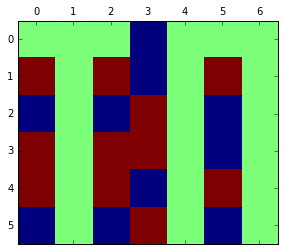

In [312]:
game = cccc.Board()
t0 = 'error'
t1=time.clock()
t2=time.clock()
t3=time.clock()
EPSILON = 0.1
for move in  [3,3,3,5,5,2,3,5,2,5,2,0,5,3,0,2,0,0,2,3,0]:
    game.update_move(move)
if board_to_cache(game.board) in TREE_CACHE:
    tree = TREE_CACHE[board_to_cache(game.board)]
else:
    tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,leaf_branch=5)
for _ in range(1000):
    display.clear_output(wait=True)
    MCTS(tree,game,cccc.Board,dur = 0.25,leaf_branch=5,mix=0.9999)

    print print_eval(tree)
    if not any([val[0] == 0.5 for val in tree.R.values()]):
        break
board_to_paint(game.board)

move 1: eval:  win in  1 runs:     2 principal branch: 1



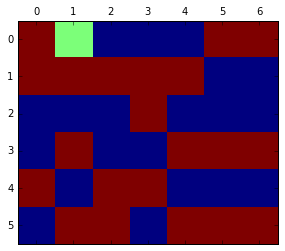

KeyError: '__________________________________________'

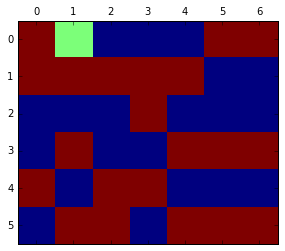

In [494]:
t0 = 'error'
game = cccc.Board()
t1=time.clock()
t2=time.clock()
t3=time.clock()
MC_cache = {}
AB_cache = {}
net_cache = {}
MCAB_cache = {}
MCABroll_cache = {}
EPSILON = 0.1
time_per_move = 5
update_freq = 0.25
ax = plt.gca()
win_d = {1:'win',0:'tie',-1:'loss'}

pass_policy = lambda x: net_to_policy(net,x,temp = 0.25)

score = 0
games = 0

for i in range(100):
    game = cccc.Board()
    tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,leaf_branch=5,cache = MC_cache)
    players = {1:'MCnetAB',-1:'MCnet'}

    while game.game_over() == False:
        if players[game.player] == 'AB':
            display.clear_output(wait=True)

            move_score_depth = alpha_beta_descend(game,cache = AB_cache,dur = time_per_move)
            print 'move: {}, score: {}, depth: {}'.format(move_score_depth[0][0],move_score_depth[0][1][0],move_score_depth[1])

            game.update_move(move_score_depth[0][0])
            ax = board_to_plot(ax,game.board)
            display.display(plt.gcf())
            continue
        if players[game.player] == 'MC':
            if board_to_cache(game.board) in MC_cache:
                tree = MC_cache[board_to_cache(game.board)]
            else:
                tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,leaf_branch=5,cache = MC_cache)

            for _ in range(int(time_per_move / update_freq)):
                display.clear_output(wait=True)
                MCTS(tree,game,cccc.Board,dur = update_freq,leaf_branch=5,mix = 0.9999)
    #             ax = board_to_plot(ax,game.board)
    #             display.display(plt.gcf())
                if 'AB' in players.values():
                    print 'move: {}, score: {}, depth: {}'.format(move_score_depth[0][0],move_score_depth[0][1][0],move_score_depth[1])
                print print_eval(tree)

    #         board_to_paint(game.board)
            game.update_move(principal(tree)[0][0])
            continue
        if players[game.player] == 'MCnet':
            if board_to_cache(game.board) in net_cache:
                tree = net_cache[board_to_cache(game.board)]
            else:
                tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,policy = pass_policy,leaf_branch=5,cache = net_cache)

            for _ in range(int(time_per_move / update_freq)):
                display.clear_output(wait=True)
                MCTS(tree,game,cccc.Board,dur = update_freq,leaf_branch=5,policy = pass_policy,net = net, mix = 0.5)
    #             ax = board_to_plot(ax,game.board)
    #             display.display(plt.gcf())
                if 'AB' in players.values():
                    print 'move: {}, score: {}, depth: {}'.format(move_score_depth[0][0],move_score_depth[0][1][0],move_score_depth[1])
                print print_eval(tree)

    #         board_to_paint(game.board)
            game.update_move(principal(tree)[0][0])
            continue

        if players[game.player] == 'MCnetAB':
            if board_to_cache(game.board) in MCAB_cache:
                tree = net_cache[board_to_cache(game.board)]
            else:
                tree = MCTS_node(cccc.Board,np.copy(game.board),game.player,policy = pass_policy,leaf_branch=5,cache = MCAB_cache)

            for _ in range(int(time_per_move / update_freq)):
                display.clear_output(wait=True)
                MCTS(tree,
                     game,cccc.Board,
                     dur = update_freq,
                     leaf_branch=5,
                     policy = pass_policy,
                     net = net,
                     mix = 0.5,
                     rollout_policy= alpha_beta_rollout(2,MCABroll_cache))
    #             ax = board_to_plot(ax,game.board)
    #             display.display(plt.gcf())
                if 'AB' in players.values():
                    print 'move: {}, score: {}, depth: {}'.format(move_score_depth[0][0],move_score_depth[0][1][0],move_score_depth[1])
                print print_eval(tree)

    #         board_to_paint(game.board)
            game.update_move(principal(tree)[0][0])
            continue
    ax = board_to_plot(ax,game.board)
    display.display(plt.gcf())
    score += game.result
    games +=1
print 'score: {}, games: {}'.format(score,games)

In [482]:
game.board

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [477]:
game.legal_moves()[policy_to_index(alpha_beta_rollout(2,MCABroll_cache)(np.zeros((6,7))))]

2

In [396]:
alpha_beta(game,2)

(6, (0, 0))

In [444]:
game = cccc.Board(np.zeros((6,7)),1)

In [399]:
alpha_beta(game,depth = 2,cache = MCAB_cache)

<__main__.MCTS_node instance at 0x000000002C4AF0C8>